In [39]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from datetime import datetime, timezone

from tqdm import tqdm
import torch
import torch.nn as nn
from torch.distributions.normal import Normal

from source.ML import HelperFunction
from source.ML import Models

In [40]:
# Import Data

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_PATH = os.path.join("..", "..", "data")

def load_csv(filename, path=DATA_PATH):
    return pd.read_csv(os.path.join(path, filename))

def to_utc_datetime(df, column="time"):
    df[column] = df.apply(lambda row: datetime.strptime(row[column], "%Y-%m-%d %H:%M:%S%z").astimezone(timezone.utc), axis=1)
    return df

def get_price():
    e_data = load_csv("energy_dataset.csv")
    return e_data[["time", "price day ahead", "total load actual", "price"]].rename(
        columns={"price day ahead": "TSO_price_forecast",
                 "total load actual": "load"})

def add_weather_data(df):
    w_data = load_csv("weather_features.csv").drop(columns=["weather_id", "weather_icon", "temp_min", "temp_max"])
    w_data = w_data.join(other=df.set_index("time"), on="time").drop_duplicates(subset=["time", "city_name"])
    return w_data.reset_index(drop=True)

data = to_utc_datetime(add_weather_data(get_price()))
data.drop(columns=["weather_main", "weather_description", "TSO_price_forecast"], inplace=True)
data.fillna(method="ffill", inplace=True)
data = data.drop(columns=["city_name"]).groupby(by=["time"]).mean()

In [41]:
# select features

target_column = "price"
features = ["temp", "pressure", "humidity", "wind_speed", "wind_deg", "rain_1h", "rain_3h", "snow_3h", "clouds_all", "load", "price"]
#features = ["price"]
num_features = len(features)
data = data.loc[:, features]

In [42]:
# split train/test

target_year = 2018
train_data = data.loc[data.index.year < target_year]
test_data = data.loc[data.index.year == target_year]

In [43]:
# scale data

scaler_y = MinMaxScaler()
scaler_y.fit(train_data[target_column].values.reshape(-1, 1))

scaler = MinMaxScaler()

train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

In [44]:
# create ML-problem by creating a input sequences and corresponding labels

seq_len = 48 #24*7
out_seq_len = 24
X, y = HelperFunction.create_input_output_sequence(train_data_scaled, seq_len, out_seq_len)
X = torch.FloatTensor(X).to(device)
y = torch.FloatTensor(y).to(device)

In [45]:
# define model

mini_batch = 100
model = Models.LSTMSeq2SeqOle(input_dim=num_features, out_seq_len=out_seq_len, hidden_dim=84)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.to(device)

LSTMSeq2SeqOle(
  (lstm_in): LSTM(11, 84, batch_first=True)
  (lstm_repeat): LSTM(84, 84, batch_first=True)
  (linear): Linear(in_features=84, out_features=1, bias=True)
)

In [46]:
# train model

epochs = 6000

for i in tqdm(range(epochs)):
    # train
    idx = np.random.choice(X.shape[0], mini_batch, replace=False)
    optimizer.zero_grad()
    y_pred = model(X[idx])
    single_loss = loss(y_pred, y[idx])
    single_loss.backward()
    optimizer.step()
    if i%500 == 0:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

100%|██████████| 6000/6000 [01:04<00:00, 93.39it/s] 


epoch:   0 loss: 0.15510018
epoch: 500 loss: 0.00823042
epoch: 1000 loss: 0.00679335
epoch: 1500 loss: 0.00454345
epoch: 2000 loss: 0.00502727
epoch: 2500 loss: 0.00405978
epoch: 3000 loss: 0.00311954
epoch: 3500 loss: 0.00349919
epoch: 4000 loss: 0.00352404
epoch: 4500 loss: 0.00272701
epoch: 5000 loss: 0.00274682
epoch: 5500 loss: 0.00278270
epoch: 5999 loss: 0.0024923040


In [47]:
# predict test-data

prediction = HelperFunction.predict(model, np.vstack((train_data_scaled[-seq_len:], test_data_scaled)), seq_len)

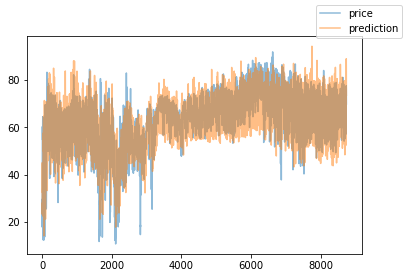

In [48]:
# plot prediction

f_o = 23 # offset into the future: 0 next hour, 1 prediction of next hour + 1; must be < out_seq_len
prediction_real = scaler_y.inverse_transform(prediction[:, f_o].reshape(-1, 1))
last_test_data_index = min(len(test_data), f_o + prediction_real.shape[0])
prediction_df = test_data[f_o: last_test_data_index].assign(prediction=prediction_real[0: last_test_data_index - f_o])
prediction_df.reset_index(inplace=True)

plt.plot(prediction_df.index, prediction_df[target_column], label=target_column, alpha=0.5)
plt.plot(prediction_df.index, prediction_df["prediction"], label="prediction", alpha=0.5)
plt.gcf().legend()

In [49]:
# stats for all predictions by hours into the future, i.e. always next hour, next hour + 1, etc.

stats = []
for f_o in tqdm(range(prediction.shape[1])):
    prediction_real = scaler_y.inverse_transform(prediction[:, f_o].reshape(-1, 1))
    last_test_data_index = min(len(test_data), f_o + prediction_real.shape[0])
    prediction_df = test_data[f_o: last_test_data_index].assign(prediction=prediction_real[0: last_test_data_index - f_o])
    prediction_df.reset_index(inplace=True)
    foobar = HelperFunction.TimeSeriesPlot(prediction_df, target_column, "prediction")
    stats.append([foobar.rmse(), foobar.mape(), foobar.mae()])
df_stats = pd.DataFrame(stats, columns=["rmse", "mape", "mae"])
df_stats

100%|██████████| 24/24 [00:00<00:00, 105.76it/s]


,rmse,mape,mae
0,3.535336,4.730353,2.715249
1,4.363242,5.869746,3.369234
2,4.943790,6.674046,3.804195
3,5.443795,7.385332,4.191341
4,5.780015,7.890871,4.442234
5,6.000101,8.233816,4.586440
6,6.136525,8.458388,4.657779
7,6.233887,8.603731,4.692023
8,6.334596,8.738997,4.733612
9,6.459838,8.918937,4.813281


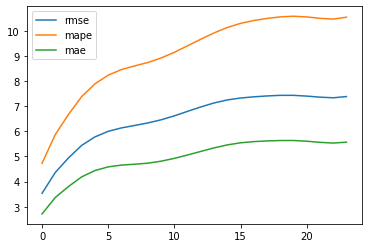

In [50]:
# plot stats

stat_plot = df_stats.plot()

In [51]:
# saliancy per timestep

sal_sample = HelperFunction.saliancy_per_sample(model, np.vstack((train_data_scaled[-seq_len:], test_data_scaled)), seq_len)

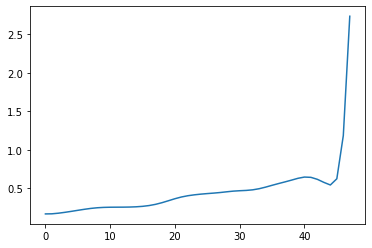

In [52]:
# plot saliancy per timestep

plt.plot(np.mean(sal_sample, axis=0))

In [53]:
# saliancy per timestep per feature

sal_feature = HelperFunction.saliancy_per_feature(model, np.vstack((train_data_scaled[-seq_len:], test_data_scaled)), seq_len)

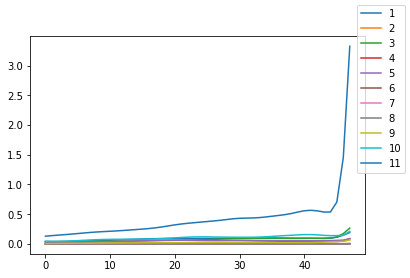

In [54]:
# plot saliancy per timestep per feature

for i in range(0, num_features):
    plt.plot(np.mean(sal_feature[:,:,i], axis=0), label=i+1)

plt.gcf().legend()